In [1]:
import torch
import pytorch_lightning as pl

device_str = 'cuda:3'
device = torch.device(device_str if torch.cuda.is_available() else "cpu")

torch.cuda.set_device(device)

from hydra.utils import instantiate
from hydra.experimental import initialize, compose

import numpy as np
import time 
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(184)
np.random.seed(143)

print(torch.__version__)
print(device)

1.8.1+cu102
cuda:3


In [2]:
from bliss import sleep

In [3]:
import sys
sys.path.append('./starnet_utils/')
import m2_data
import plotting
import starnet_metrics
import utils

In [4]:
%matplotlib inline

# Load configs and starnet model

In [5]:
with initialize(config_path='./scripts/'):
    cfg = compose("m2")

print('config: ')
print(cfg)

config: 
{'mode': 'train', 'gpus': 1, 'paths': {'root': None, 'output': '${paths.root}/output', 'sdss': '${paths.root}/data/sdss', 'data': '${paths.root}/data'}, 'datasets': {'simulated_m2': {'_target_': 'bliss.datasets.simulated.SimulatedDataset', 'prior': '${models.prior}', 'decoder': '${models.decoder}', 'background': [686.0, 1123.0], 'n_batches': 10, 'batch_size': 20, 'generate_device': 'cuda:0', 'testing_file': None}}, 'models': {'decoder': {'_target_': 'bliss.models.decoder.ImageDecoder', 'n_bands': 2, 'tile_slen': 2, 'ptile_slen': 26, 'border_padding': 3, 'psf_params_file': '../../../data/sdss/2583/2/136/psField-002583-2-0136.fits', 'sdss_bands': [2, 3]}, 'encoder': {'_target_': 'bliss.models.location_encoder.LocationEncoder', 'n_bands': '${models.decoder.n_bands}', 'tile_slen': '${models.decoder.tile_slen}', 'ptile_slen': 8, 'max_detections': 2, 'channel': 17, 'spatial_dropout': 0.11399, 'dropout': 0.013123, 'hidden': 185}, 'prior': {'_target_': 'bliss.models.prior.ImagePrior',

/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/initialize.py:35: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  warnings.warn(
/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/compose.py:16: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  warnings.warn(


In [6]:
cfg.datasets.simulated_m2.update({'generate_device': device_str})

In [7]:
cfg.models.decoder.update({'psf_params_file': './../../data/sdss/2583/2/136/psField-002583-2-0136.fits'})

In [8]:
cfg.models.prior.update({'mean_sources': 0.2})

# Define models

In [9]:
model_filename = './fits/starnet-sparse'

dataset = instantiate(cfg.training.dataset)

sleep_net = instantiate(cfg.training.model,
                        optimizer_params=cfg.training.optimizer_params)

sleep_net.image_encoder.load_state_dict(torch.load(model_filename)); 

In [10]:
sleep_net.image_encoder.to(device);
sleep_net.image_encoder.eval(); 

In [11]:
from bliss.datasets import simulated 
cfg.datasets.simulated_m2.update({'batch_size': 1})
dataset = instantiate(cfg.training.dataset)

batch = dataset.get_batch()

In [12]:
batch['images'].shape

torch.Size([1, 2, 106, 106])

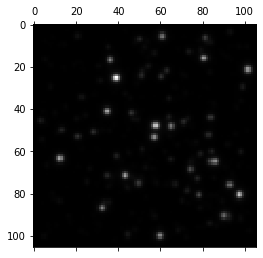

In [13]:
plt.matshow(batch['images'][0, 0].cpu(), 
            cmap=plt.cm.get_cmap("gray"))

# MAP estimates

In [15]:
from bliss.models.location_encoder import (
    get_full_params_from_tiles,
    get_images_in_tiles,
    subtract_bg_and_log_transform,
)

In [16]:
def get_map_estimate(image_encoder, images, background, slen: int, wlen: int = None):
    # return full estimate of parameters in full image.
    # NOTE: slen*wlen is size of the image without border padding

    if wlen is None:
        wlen = slen
    assert isinstance(slen, int) and isinstance(wlen, int)
    # check image compatibility
    border1 = (images.shape[-2] - slen) / 2
    border2 = (images.shape[-1] - wlen) / 2
    assert border1 == border2, "border paddings on each dimension differ."
    assert slen % image_encoder.tile_slen == 0, "incompatible slen"
    assert wlen % image_encoder.tile_slen == 0, "incompatible wlen"
    assert border1 == image_encoder.border_padding, "incompatible border"

    # obtained estimates per tile, then on full image.
    log_images = subtract_bg_and_log_transform(images, background)
    log_image_ptiles = get_images_in_tiles(
        log_images, image_encoder.tile_slen, image_encoder.ptile_slen
    )
    var_params = image_encoder.encode(log_image_ptiles)
    # var_params2 = image_encoder.encode(log_image_ptiles[:, :25, :25])
    # assert torch.allclose(var_params[0, :25, :25], var_params2, atol=1e-5)
    tile_map = image_encoder.max_a_post(var_params)

    return get_full_params_from_tiles(tile_map, image_encoder.tile_slen)

In [17]:
map_est = get_map_estimate(sleep_net.image_encoder, 
                           batch['images'],
                           dataset.background.view(1, 2, 1, 1).to(device), 
                           slen = 100)


nelec_per_nmgy = 856
map_locs = map_est['locs'].squeeze(0) * 100
map_mags = utils.convert_nmgy_to_mag(map_est['fluxes'][0, :, 0:1] / nelec_per_nmgy)

In [18]:
map_est['n_sources']

tensor([399], device='cuda:3')

In [19]:
true_params = get_full_params_from_tiles({key: batch[key] for key in ['locs', 'fluxes', 'n_sources']},
                                         sleep_net.image_encoder.tile_slen)

In [20]:
true_params['n_sources']

tensor([477], device='cuda:3')

In [21]:
true_locs = true_params['locs'].squeeze(0) * 100
true_mags = utils.convert_nmgy_to_mag(true_params['fluxes'][0, :, 0:1] / nelec_per_nmgy)

In [22]:
from starnet_metrics import get_tpr_ppv

In [23]:
get_tpr_ppv(true_locs,
            true_mags,
            map_locs,
            map_mags,
            slack = 0.5)

(tensor(0.7358, device='cuda:3'), tensor(0.8922, device='cuda:3'))

In [24]:
def get_tpr_as_dist_from_tile(): 
    dist_bins = [0., 0.1, 0.2, 0.3, 0.5, np.inf]
    
    # distance from border of true locations
    tile_slen = sleep_net.image_encoder.tile_slen
    coord_from_border = torch.min(true_locs % tile_slen,
                                  tile_slen - true_locs % tile_slen)

    linf_dist = torch.min(coord_from_border, 1).values
    
    tpr_vec = np.zeros(len(dist_bins) - 1)
    counts_vec = np.zeros(len(dist_bins) - 1)
    for i in range(len(dist_bins) - 1):
        mask = (linf_dist >= dist_bins[i]) & (linf_dist < dist_bins[i + 1])
        
        counts_vec[i] = sum(mask)

        tpr_vec[i] = get_tpr_ppv(
                            true_locs[mask],
                            true_mags[mask],
                            map_locs,
                            map_mags,
                            slack = 0.5
                        )[0]
        
    return tpr_vec, dist_bins, counts_vec



def get_ppv_as_dist_from_tile(): 
    dist_bins = [0., 0.1, 0.2, 0.3, 0.5, np.inf]
    
    # distance from border of **estimated** locations
    tile_slen = sleep_net.image_encoder.tile_slen
    coord_from_border = torch.min(map_locs % tile_slen,
                                  tile_slen - map_locs % tile_slen)

    linf_dist = torch.min(coord_from_border, 1).values
    
    ppv_vec = np.zeros(len(dist_bins) - 1)
    counts_vec = np.zeros(len(dist_bins) - 1)
    for i in range(len(dist_bins) - 1):
        mask = (linf_dist >= dist_bins[i]) & (linf_dist < dist_bins[i + 1])
        
        
        counts_vec[i] = sum(mask)
        
        ppv_vec[i] = get_tpr_ppv(
                            true_locs,
                            true_mags,
                            map_locs[mask],
                            map_mags[mask],
                            slack = 0.5
                        )[1]
    
    return ppv_vec, dist_bins, counts_vec

In [25]:
tpr_vec, dist_bins, counts_vec = get_tpr_as_dist_from_tile()
print(counts_vec)

[102.  76.  84.  93. 122.]


In [26]:
ppv_vec, dist_bins, counts_vec = get_ppv_as_dist_from_tile()
print(counts_vec)

[ 24.  68.  76. 120. 111.]


In [27]:
ppv_vec

array([0.91666669, 0.95588237, 0.85526317, 0.90000004, 0.86486489])

In [28]:
dist_bins

[0.0, 0.1, 0.2, 0.3, 0.5, inf]

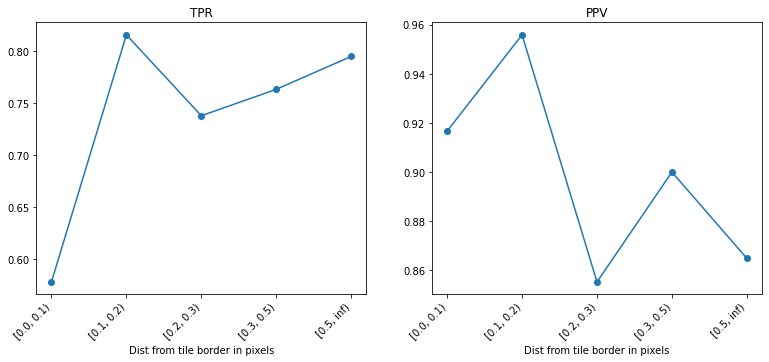

In [29]:
fig, axarr = plt.subplots(1, 2, figsize=(13, 5))

_x = np.arange(len(tpr_vec))
axarr[0].plot(_x,
              tpr_vec,
              '-o')
axarr[0].set_title('TPR')

axarr[1].plot(_x,
              ppv_vec,
              '-o')
axarr[1].set_title('PPV')



labels = ['[' + str(dist_bins[i]) + ', ' + str(dist_bins[i+1]) + ')' for i in range(len(dist_bins) - 1)]

# labels[0] = '< ' + str(labels_raw[1])
# labels[-1] = '> ' + str(labels_raw[-2])

for i in range(2): 
    axarr[i].set_xticks(_x)
    axarr[i].set_xticklabels(labels, rotation=45, ha = 'right')
    axarr[i].set_xlabel('Dist from tile border in pixels')


In [30]:
# distance from border of true locations
tile_slen = sleep_net.image_encoder.tile_slen
coord_from_border = torch.min(true_locs % tile_slen,
                              tile_slen - true_locs % tile_slen)

linf_dist = torch.min(coord_from_border, 1).values

mask = linf_dist < 0.1

In [35]:
true_locs[mask]

tensor([[ 3.9725, 50.2728],
        [ 3.7614, 53.9655],
        [ 3.2420, 67.9127],
        [ 4.9349, 60.0921],
        [ 7.8652, 69.9334],
        [ 6.0693, 81.0285],
        [ 8.7525, 50.0114],
        [ 8.0646, 57.4607],
        [ 8.0576, 78.6618],
        [ 8.9516, 97.9139],
        [11.9070, 76.8516],
        [12.0967, 15.4792],
        [13.1281, 63.9361],
        [13.4741, 77.9057],
        [14.0463,  2.5613],
        [15.9286, 20.9181],
        [15.9519, 83.4879],
        [17.4125, 28.0741],
        [18.2916,  6.0373],
        [21.9793, 69.3728],
        [20.0515, 99.9378],
        [22.0693, 47.2923],
        [22.9464, 56.0889],
        [27.5932, 79.9737],
        [29.7122, 35.9117],
        [29.9618, 69.2150],
        [31.9978, 20.0326],
        [30.0830, 21.6843],
        [30.0450, 93.4043],
        [33.2451, 22.0975],
        [32.0047, 48.6033],
        [34.3963,  1.9149],
        [34.4820, 22.0562],
        [34.0107, 59.6713],
        [35.9918, 93.5243],
        [38.5877, 32

In [36]:
map_est['locs'].shape

torch.Size([1, 399, 2])

In [37]:
batch['images'][0, 0].shape

torch.Size([106, 106])

59

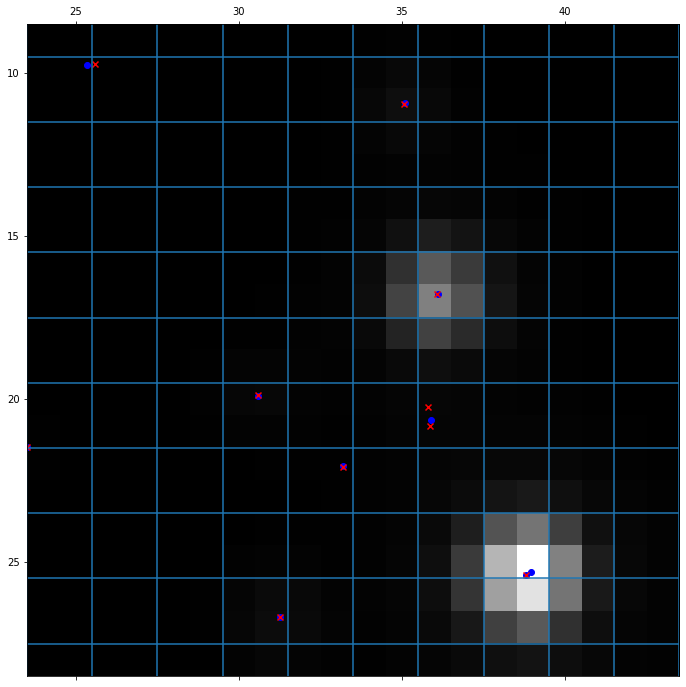

In [83]:
fig, axarr = plt.subplots(1, 1, figsize=(18, 12))

_x0 = torch.randint(3, 83, (1, )).numpy()[0]
_x1 = torch.randint(3, 83, (1, )).numpy()[0]

subimage_slen = 20

im = plotting.plot_image(axarr, 
                         batch['images'][0, 0, ],
                         _x0, 
                         _x1,
                         subimage_slen,
                         subimage_slen)

# true
plotting.plot_locations(
    true_locs.detach().cpu() + 3, 
    axarr,
    marker='o',
    color='b',
)

# estimated
plotting.plot_locations(
    map_locs.detach().cpu() + 3, 
    axarr,
    marker='x',
    color='r',
)

for i in range(50):
    axarr.axvline(2 * i + 
                  0.5 +
                  sleep_net.image_encoder.border_padding)
    
    axarr.axhline(2 * i + 
                  0.5 +
                  sleep_net.image_encoder.border_padding)